# Introduction

- Systèmes de recommandations omniprésents de nos jours : Netflix et Youtube 
- Enjeux économiques et commerciaux
- Filtrage basé sur le contenu
- Filtrage collaboratif
- Systèmes hybrides

# 1. Affichage des données

## 1.1 Fichier des utilisateurs

In [75]:
import numpy as np
import progressbar

np.seterr(divide='ignore', invalid='ignore')

import pandas as pd
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
encoding='latin-1')

users.head(10)
n_users = users.shape[0]
print('Nombre d\'utilisateurs= ' + str(n_users))

Nombre d'utilisateurs= 943


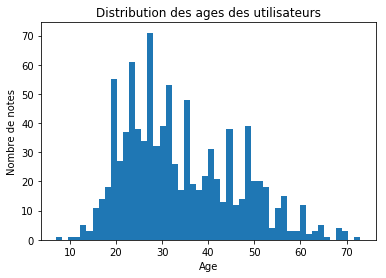

In [76]:
users.age.plot.hist(bins=50)
plt.title("Distribution des ages des utilisateurs")
plt.ylabel('Nombre de notes')
plt.xlabel('Age');

## 1.2 Fichier des films

In [77]:
i_cols = ['movie id', 'movie_title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols,
 encoding='latin-1')

items.head(3)

n_items = items.shape[0]
print('Nombre de films = ' + str(n_items))

Nombre de films = 1682


## 1.3 Fichier des notes


In [78]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
 encoding='latin-1')

ratings.head(10)
n_ratings = ratings.shape[0]
print('Nombre de notes = ' + str(n_ratings))

Nombre de notes = 100000


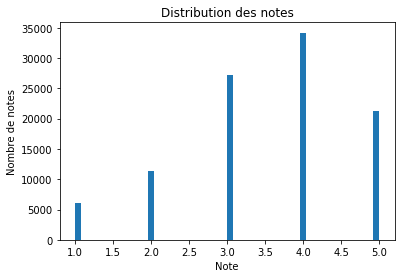

In [79]:
ratings.rating.plot.hist(bins=50)
plt.title("Distribution des notes")
plt.ylabel('Nombre de notes')
plt.xlabel('Note');

# 2. Filtrage colaboratif

## 2.1 Notations

- $n_u$ : nombre d'utilisateur 
- $n_f$ : nombre de films
- $n_r$ : nombre de notes

In [80]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('ml-100k/u.data', sep='\t', names=header)

n_u = df.user_id.unique().shape[0]
n_f = df.item_id.unique().shape[0]

print('Nombre d\'utilisateurs : '+ str(n_u))
print('Nombre de films : '+ str(n_f))

Nombre d'utilisateurs : 943
Nombre de films : 1682


## 2.2 Création de sous fichiers d'apprentissage et de test

- Utilisation du module $\verb|sparse|$ de Scipy : stockage et accès des données facilités

In [81]:
from scipy.sparse import *

def read_data_100k(filename):
    """
    Objet : retourne une matrice creuse qui contient les notes données par les utilisateurs aux films
    Arguments : le chemin du fichier des données sous format .base ou .test
    Sortie : matrice creuse des notes
    """
    data=pd.read_csv(filename, sep='\t', names=header)
    
    df = pd.read_csv('ml-100k/u.data', sep='\t', names=header)
    
    n_u = df.user_id.unique().shape[0]
    n_f = df.item_id.unique().shape[0]
    
    users=[]
    films=[]
    ratings=[]
    
    for line in data.itertuples():
        users.append(line[1]-1)
        films.append(line[2]-1)
        ratings.append(line[3])
        
    return csr_matrix((ratings, (users, films)), shape=(n_u, n_f))


- $\verb|train_data|$ : données d'aprentissage  
- $\verb|test_data|$ : données de test

In [82]:
train_data=read_data_100k('ml-100k/u1.base')
test_data=read_data_100k('ml-100k/u1.test')

- Prédécoupage réalisé par Movie-Lense : 20%/80%

In [83]:
print('Nombre de notes dans train_data : '+str(csr_matrix.count_nonzero((train_data))))

print('Nombre de notes dans test_data : '+str(csr_matrix.count_nonzero((test_data))))

Nombre de notes dans train_data : 80000
Nombre de notes dans test_data : 20000


## 2.3 Création de la matrice de similarité

- Comment mesurer la similarité entre deux utilisateurs ou deux films ?
- Métrique couramment utilisée : cosinus

Pour les utilisateurs : $s_u^{cos}(u_i,u_j)=\frac{u_i u_j}{||u_i||\times||u_j||}$ où $u_i$ est un vecteur comportant toutes les notes du ième utilisateur

Pour les films : $s_f^{cos}(f_i,f_j)=\frac{f_i f_j}{||f_i||\times||f_j||}$ où $f_i$ est un vecteur comportant toutes les notes du ième film

In [85]:
import sklearn.preprocessing as pp

def cosine_similarities(mat):
    """
    Objet : calculer la similarité cosinus entre les colonnes d'une matrice
    Arguments : matrice creuse des notes
    Sortie : matrice de similarité
    """
    col_normed_mat = pp.normalize(mat.tocsc(), axis=0)
    return col_normed_mat.T * col_normed_mat

user_similarity=cosine_similarities(train_data.T)
film_similarity=cosine_similarities(train_data)

## 2.4 Objectif

- $V(u,f)$ : note"vraie" contenu dans $\verb|test_data|$
- $N(u,f)$ : note contenu
- $P(u,f)$ : note prédite calculée à partir de $\verb|train_data|$
- Objectif : s'approcher de $V$ en prédisant $P$ à l'aide des $N$

## 2.5 Filtrage colloboratif utilisateur


$$P(u_i,f_j)-\bar{N}(u_i)=\frac{\sum_{k\neq i} s_u^{cos}(u_i,u_k)\left(N(u_k,f_j)-\bar{N}(u_k)\right)}{\sum_{k\neq i}|s_u^{cos}(u_i,u_k)|}$$

- Prédit l'écart à la moyenne pour plus de sens

<img src="Image/2.png">

## 2.6 Filtrage colloboratif film


$$P(u_i,f_j)=\frac{\sum_{k\neq j} s_u^{cos}(f_j,f_l)\times N(u_i,f_l)}{\sum_{l\neq j}|s_u^{cos}(f_j,f_l)|}$$

<img src="Image/1.png">

## 2.7 Implémentation

In [86]:
import numpy

def mean_users(ratings):
    """
    Objet : calculer la moyenne des notes de chaque utilisateur
    Arguments : matrice qui contient les notes
    Sortie : liste dont les élements representent la note moyenne pour chaque utilisateur
    """
    (x,y,z)=find(ratings)
    countings=numpy.bincount(x)
    sums=numpy.bincount(x,weights=z)
    averages=sums/countings
    return averages
        
def predict(u,f,train_data,similarity,method) :
    """
    Objet : predire la note d'un film donné pour un utilisateur donné selon une méthode spécifique 
    Arguments : - u : l'id de l'utilisateur
                - f : l'id du film
                - train_data : la matrice d'apprentissage
                - similarity : la matrice de similarité
                - method : méthode choisie "film" ou "user"
    Sortie : un float qui représente la note predite
    """
    if method=='film':
        mean_us= mean_users(train_data)
        temp=0
        tempsimil=0
        ratings_u=train_data[u,:]
        (_,films,r)=find(ratings_u)
        for film in films:
            temp+=similarity[f,film]*train_data[u,film]
            tempsimil+=similarity[f,film]
        
        if np.isnan(mean_us[u]):
            return 3
        elif tempsimil==0 :
            return mean_us[u]
        else :
            return temp/tempsimil
        
    if method=='user':
        mean_us= mean_users(train_data)
        temp=0
        tempsimil=0
        ratings_f=train_data[:,f]
        (users,_,r)=find(ratings_f)
        for user in users:
            train_data[user,f]
            mean_us[user]
            similarity[u,user]
            temp+=similarity[u,user]*(train_data[user,f]-mean_us[user])
            tempsimil+=similarity[u,user]
        
        if np.isnan(mean_us[u]):
            return 3
        elif tempsimil==0 :
            return mean_us[u]
        else :
            return mean_us[u]+temp/tempsimil

# 3. Recommendation basée sur le contenu 

- Le filtrage basé sur le contenu repose sur l'analyse du contenu pour cibler des films. 
- Les films cibles sont décrits par leurs attributs qui sont les genres qu'ils possédent. 
- Les utilisateurs sont décrits par leurs profils : age , sexe et profession. 

## 3.1 Filtrage basé sur le contenu utlisateur

In [87]:
jobs=users.occupation.unique()
nb_jobs=jobs.shape[0]

def features_matrix_users(users):
    """
    Objet : extraction des informations d'un utilisateur à partir des données MovieLense
    Arguments : données de MovieLense
    Sortie : Matrice qui contient les caractéristiques de chaque utilisateur : age, sexe et profession
    """
    L=[]
    for line in users.itertuples():
        Li=[]
        Li.append(line[2]/(users.age.max()+users.age.min()))
        Li.append(int(line[3]=='M'))
        Li.append(int(line[3]!='M'))
        for j in jobs:
            Li.append(int(line[4]==j))
        L.append(Li)
    return csr_matrix(L)



def get_similarity_user():
    """
    Objet : retourne une matrice de similarités cosinus des utilisateurs basée sur leur contenu
    """
    features_matrix_user=features_matrix_users(users)
    return cosine_similarities(features_matrix_user.T) 

- Le système de recommandation propose les films aimés par d’autres utilisateurs qui ont de hautes corrélations avec le profil de l'utilisateur en question.

## 3.2 Filtrage basé sur le contenu des films

In [88]:
def features(data_set) :
    """
    Équivalent pour les films selon les caractéristiques du genre
    """
    features_film=[];
    genres=['Action', 'Adventure','Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    for i in range(data_set.shape[0]) :
        Li=[];
        for g in genres:
            Li.append(data_set[g][i])
        Li.append(int(data_set['release date'][1][7:12]))
        features_film.append(Li)
    features_film=csr_matrix(features_film)
    return(features_film)

def get_similarity_films():
    """
    Idem
    """
    featurestemp=features(items)
    return cosine_similarities(featurestemp.T) # Les films doivent être en ligne 



- Avantages : démarrage à froid ou prèsence d'un nombre très limité de notes
- Inconvénients : analyse limitée du contenu des films / ne prend pas en compte les attributs subjectifs liés à la perception de l’utilisateur et qui peuvent influencer énormément son choix.

# 4. Test et comparaison des méthodes

## 4.1 Normalisation

- Pour pouvoir comparer les différentes méthodes
- $N_{norm}=(N-N_{min})\frac{5-1}{N_{max}-N_{min}}+1$.

In [89]:
def getNormalized(pred):
    """
    Objet : normalisation des notes entre 1 et 5
    Arguments : matrice creuse des predictions
    Sortie : matrice creuse des prédictions normalisées
    """
    n_u=pred.shape[0]
    n_f=pred.shape[1]
    
    rmax=pred.max()
    rmin=pred.min()
    (users,films,r)=find(pred)
    pred_norm=[]
    for rating in r :
        pred_norm.append((((rating-rmin)*4)/(rmax-rmin))+1)
    
    
    return(pred_norm)
        

## 4.2 Quelques fonctions

- Fonctions permettant de prédire uniquement les notes présentes dans $\verb|test_data|$
- Utilisation de matrices sparses

In [90]:
import progressbar
import time

def predict_film_all(train_data,test_data,method):
    """
    Objet : prediction de toutes les notes de la matrice test_data à partir de train_data
    Arguments : - train_data : la matrice d'apprentissage
                - test_data : la matrice de test
                - method : méthode choisie "CF" pour le filtrage collaboratif et "CB" 
                           pour le filtrage basé sur le contenu
    Sortie : une matrice creuse des notes predites pour les films déjà notés par les 
             utilisateurs dans la matrice test
    """
    if method=='CF' :
        similarity = cosine_similarities(train_data)
    if method=='CB':
        similarity=get_similarity_films()
    
    n_u=train_data.shape[0]
    n_f=train_data.shape[1]
    
    (users,films,r)=find(test_data)
    
    n_r=users.shape[0]
    
    predictions=[]
   
    bar = progressbar.ProgressBar(maxval=n_r, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for r in range(0,n_r):
        predictions.append(predict(users[r],films[r],train_data,similarity,'film'))
        bar.update(r+1)
    bar.finish()
    time.sleep(0.1)
    return csr_matrix((predictions, (users, films)), shape=(n_u, n_f))


def predict_user_all(train_data,test_data,method):
    """
    Idem pour l'approche utilisateur
    """
    if method=='CF' :
        similarity = cosine_similarities(train_data.T)
    if method=='CB':
        similarity=get_similarity_user()
    
    n_u=train_data.shape[0]
    n_f=train_data.shape[1]
    
    (users,films,r)=find(test_data)
    
    n_r=users.shape[0]
    predictions=[]
   
    bar = progressbar.ProgressBar(maxval=n_r, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for r in range(0,n_r):
        predictions.append(predict(users[r],films[r],train_data,similarity,'user'))
        bar.update(r+1)
    bar.finish()
    time.sleep(0.1)
    return csr_matrix((predictions, (users, films)), shape=(n_u, n_f))

## 4.3 Performance des algorithmes

- Comment quantifier la performance de nos algorithmes ?
- Erreur quadratique moyenne : $<(P-V)^2>$
- Utilisation du module $\verb|mean_squared_error|$ de Sklearn

In [91]:
from sklearn.metrics import mean_squared_error
from math import sqrt


def rmse(test_data,pred):
    """
    Objet : calcul de l'erreur quadratique moyenne
    Arguments : - test_data : la matrice des notes "vraies" 
                - pred : la matrice des predictions
    Sortie : l'erreur quadratique moyenne (float)
    """
    (_,_,y_actual)=find(test_data)
    (_,_,y_predicted)=find(pred)
    return(sqrt(mean_squared_error(y_actual, y_predicted)))


### CF film-film

In [92]:
#pred_film_CF=predict_film_all(train_data,test_data,'CF');

In [93]:
#save_npz('Matrices/100k/u1/pred_film_CF_film_u1.npz', pred_film_CF)
pred_film_CF=load_npz('Matrices/100k/u1/pred_CF_film_u1.npz')

In [94]:
rmse_film_CF=rmse(test_data,pred_film_CF)

print('RMSE : ' +str(rmse_film_CF))

rmse_film_CFN=rmse(test_data,getNormalized(pred_film_CF))

print('RMSE avec normalisation : ' +str(rmse_film_CFN))

RMSE : 1.0334307063086856
RMSE avec normalisation : 1.132838511008601


- La normalisation réduit les performances de l'algorithme
- RMSE cohérent avec la littérature

### CF utilisateur-film

In [95]:
#pred_user_CF=predict_user_all(train_data,test_data,'CF');

In [96]:
#save_npz('Matrices/100k/u1/pred_film_CF_user_u1.npz', pred_film_CF)
pred_user_CF=load_npz('Matrices/100k/u1/pred_CF_user_u1.npz')

In [97]:
rmse_user_CF=rmse(test_data,pred_user_CF)

print('RMSE : ' +str(rmse_user_CF))

rmse_user_CFN=rmse(test_data,getNormalized(pred_user_CF))

print('RMSE avec normalisation : ' +str(rmse_user_CFN))

RMSE : 0.9678736486371978
RMSE avec normalisation : 0.9923907778807052


- La normalisation réduit les performances de l'algorithme
- RMSE cohérent avec la littérature
- Plus performant que l'approche films

### CB film

In [98]:
#pred_film_CB=predict_film_all(train_data,test_data,'CB')

In [99]:
#save_npz('Matrices/100k/u1/pred_film_CB_film_u1.npz', pred_film_CB)
pred_film_CB=load_npz('Matrices/100k/u1/pred_CB_film_u1.npz')

In [100]:
rmse_film_CB=rmse(test_data,pred_film_CB)

print('RMSE : ' +str(rmse_film_CB))

rmse_film_CBN=rmse(test_data,getNormalized(pred_film_CB))

print('RMSE avec normalisation : ' +str(rmse_film_CBN))

RMSE : 1.0629951228349885
RMSE avec normalisation : 1.1449037361418997


- La normalisation réduit les performances de l'algorithme
- Moins performant que l'approche CF films

### CB user

In [101]:
#pred_user_CB=predict_user_all(train_data,test_data,'CB')

In [102]:
#save_npz('Matrices/100k/u1/pred_film_CB_user_u1.npz', pred_user_CB)
pred_user_CB=load_npz('Matrices/100k/u1/pred_CB_user_u1.npz')

In [103]:
rmse_user_CB=rmse(test_data,pred_user_CB)

print('RMSE : ' +str(rmse_user_CB))

rmse_user_CBN=rmse(test_data,getNormalized(pred_user_CB))

print('RMSE avec normalisation : ' +str(rmse_film_CBN))

RMSE : 0.9767450885381848
RMSE avec normalisation : 1.1449037361418997


- La normalisation réduit les performances de l'algorithme
- Moins performant que l'approche CF utilisateurs
- Plus performant que les approches CB et CF films

### Analyse sur 5 découpages différents

In [ ]:
# for u in [1,2,3,4,5]:
    print("Traitement du jeu de données : u_"+str(u) )
    
    # Read data
    train_data=read_data_100k('ml-100k/u'+str(u)+'.base')
    save_npz('Matrices/100k/u'+str(u)+'/train_data_u'+str(u)+'.npz', train_data)
    
    test_data=read_data_100k('ml-100k/u'+str(u)+'.test')
    save_npz('Matrices/100k/u'+str(u)+'/test_data_u'+str(u)+'.npz', test_data)
    
    # CF Film
    target=CF_film=predict_film_all(train_data, test_data,'CF')
    save_npz('Matrices/100k/u'+str(u)+'/pred_CF_film_u'+str(u)+'.npz', CF_film)
    
    # CF User
    CF_user=predict_user_all(train_data, test_data,'CF')
    save_npz('Matrices/100k/u'+str(u)+'/pred_CF_user_u'+str(u)+'.npz', CF_user)
    
    # CB Film
    CB_film=predict_film_all(train_data, test_data,'CB')
    save_npz('Matrices/100k/u'+str(u)+'/pred_CB_film_u'+str(u)+'.npz', CB_film)

    
    # CB User
    CB_user=predict_user_all(train_data, test_data,'CB')
    save_npz('Matrices/100k/u'+str(u)+'/pred_CB_user_u'+str(u)+'.npz', CB_user)

### Affichage des résultats

In [104]:
us=[1,2,3,4,5]  
rmses_CF_film=[]
rmses_CF_user=[]
rmses_CB_film=[]
rmses_CB_user=[]   

for u in us:
    print("Analyse du jeu de données : u_"+str(u) )
    
    # Données de test
    truth=load_npz('Matrices/100k/u'+str(u)+'/test_data_u'+str(u)+'.npz')
    
    
    # CF Film
    CF_film=load_npz('Matrices/100k/u'+str(u)+'/pred_CF_film_u'+str(u)+'.npz')
    
    rmses_CF_film.append(rmse(CF_film,truth))
        
    # CF User
    CF_user=load_npz('Matrices/100k/u'+str(u)+'/pred_CF_user_u'+str(u)+'.npz')
   
    rmses_CF_user.append(rmse(CF_user,truth))
        
        
    
    # CB Film
    CB_film=load_npz('Matrices/100k/u'+str(u)+'/pred_CB_film_u'+str(u)+'.npz')

    rmses_CB_film.append(rmse(CB_film,truth))
    
    
    # CB User
    CB_user=load_npz('Matrices/100k/u'+str(u)+'/pred_CB_user_u'+str(u)+'.npz')
    
    rmses_CB_user.append(rmse(CB_user,truth))
    
rmses_CF_film.append(np.mean(rmses_CF_film))
rmses_CB_film.append(np.mean(rmses_CB_film))
rmses_CF_user.append(np.mean(rmses_CF_user))
rmses_CB_user.append(np.mean(rmses_CB_user))

rmses=[rmses_CF_film,rmses_CF_user,rmses_CB_film,rmses_CB_user] 


col1 = ['CF_film','CF_user','CB_film','CB_user']
col2 = ['u1','u2','u3','u4','u5','Moyenne']
df = pd.DataFrame(rmses,index = col1, columns = col2)

df.head(8)

Analyse du jeu de données : u_1
Analyse du jeu de données : u_2
Analyse du jeu de données : u_3
Analyse du jeu de données : u_4
Analyse du jeu de données : u_5


,u1,u2,u3,u4,u5,Moyenne
CF_film,1.033431,1.016996,1.004512,1.009916,1.011191,1.015209
CF_user,0.967874,0.958156,0.951901,0.948146,0.947751,0.954766
CB_film,1.062995,1.046747,1.032896,1.036658,1.039292,1.043718
CB_user,0.976745,0.966675,0.959598,0.957702,0.957205,0.963585


- Confirmation des résultats
- Possibilités d'hybrider ?

# 5. Hybridation

- Quels sont les paramètres qui quantifient la justesse de l'estimation ?
- Le nombre de films qu'un utilsateur a vus pour la méthode orienté utilisateur ?
$$P(u_i,f_j)-\bar{N}(u_i)=\frac{\sum_{k\neq i} s_u^{cos}(u_i,u_k)\left(N(u_k,f_j)-\bar{N}(u_k)\right)}{\sum_{k\neq i}|s_u^{cos}(u_i,u_k)|}$$
- Le nombre d'utilsateurs qui ont vus un film pour la méthode orienté film ?
$$P(u_i,f_j)=\frac{\sum_{l\neq j} s_u^{cos}(f_j,f_l)\times N(u_i,f_l)}{\sum_{l\neq j}|s_u^{cos}(f_j,f_l)|}$$

## 5.1 Fonction pour calculer le nombre de films vus pour un utilisateur donné

- Conditionne apriori la performance de l'approche film

In [105]:
def get_allnfsus(train_data): 
    """
    Objet : calcul du nombre de films vus par chaque utilisateur
           (Number of Films Seen by User)
    Arguments : train_data, la matrice d'apprentissage
    Sortie : une liste des NFSU de taille n_u 
    """
    n_u=train_data.shape[0]
    nfsus=[]
    for u in range(n_u):
        nfsus.append(train_data[u,:].count_nonzero())
    return np.array(nfsus)


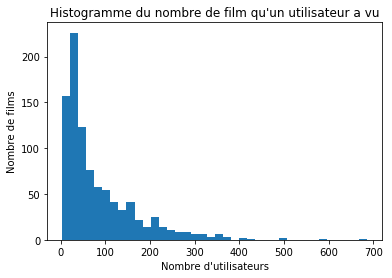

In [106]:
allnufs=get_allnfsus(train_data);

plt.hist(allnufs,bins='auto')
plt.title("Histogramme du nombre de film qu'un utilisateur a vu")
plt.xlabel('Nombre d\'utilisateurs')
plt.ylabel('Nombre de films');
plt.show()

- Décroissance rapide : la majorité des utilisateurs ont vu moins de 100 films

## 5.2 Fonctions pour calculer le nombre d'utilisateurs qui on vu un film donné

- Conditionne apriori la performance de l'approche user

In [107]:
def get_allnusfs(train_data): 
    """
    Objet : calcul du nombre d'utilisateurs qui ont regardé chaque film
            (Number of Users that Saw one Film)
    Arguments : train_data, la matrice d'apprentissage
    Sortie : une liste des NUSF de taille n_f
    """
    n_f=train_data.shape[1]
    nusfs=[]
    for f in range(n_f):
        nusfs.append(train_data[:,f].count_nonzero())
    return np.array(nusfs)

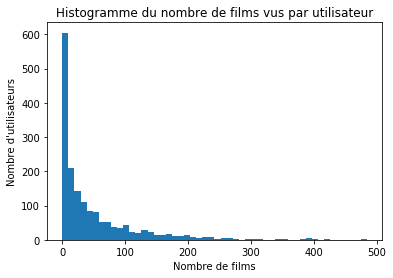

In [108]:
allnfsus=get_allnusfs(train_data);

plt.hist(allnfsus,bins='auto')
plt.title("Histogramme du nombre de films vus par utilisateur")
plt.ylabel('Nombre d\'utilisateurs')
plt.xlabel('Nombre de films');
plt.show()

- Décroissance rapide : la majorité des films ont été vus moins de 40 fois
- Ceci explique que CF utilisateurs est plus performant que CF films

### Évaluation de la dépendance des méthodes orientées user

In [109]:
def rmse_fonction_user(pred,test_data):
    """
    Objet : calcul des RMSE pour chaque utilisateur
    Arguments : - pred : la matrice des predictions 
                - test_data : la matrice de test
    Sortie : la liste des RMSE pour chaque utilisateur de taille n_u 
    """
    n_u=pred.shape[0]

    RMSE=[]
    zeros=[]
    for u in range(n_u):
        (_,_,predu)=find(pred[u,:])
        (_,_,truthu)=find(test_data[u,:])
        if predu.shape[0]!=0 :
            RMSE.append(rmse(predu,truthu))
        else :
            RMSE.append(np.nan)
    return RMSE


In [110]:
def rmse_fonction_film(pred,test_data):
    """
    Objet : calcul des RMSE pour chaque film
    Arguments : - pred : la matrice des predictions 
                - test_data : la matrice de test
    Sortie : la liste des RMSE pour chaque film de taille n_f
    """
    n_f=test_data.shape[1]

    RMSE=[]
    zeros=[]
    for f in range(n_f):
        (_,_,predf)=find(pred[:,f])
        (_,_,truthf)=find(test_data[:,f])
        if predf.shape[0]!=0:
            RMSE.append(rmse(truthf,predf))
        else :
            RMSE.append(np.nan)
    return RMSE

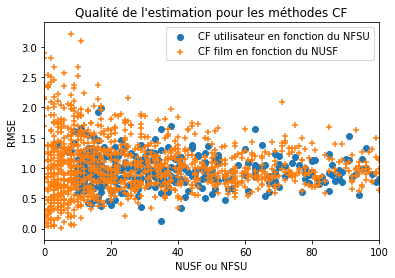

In [111]:
predCFuser=load_npz('Matrices/100k/u1/pred_CF_user_u1.npz')
predCFfilm=load_npz('Matrices/100k/u1/pred_CF_film_u1.npz')
test_data=load_npz('Matrices/100k/u1/test_data_u1.npz')
train_data=load_npz('Matrices/100k/u1/train_data_u1.npz')

nfsus=get_allnfsus(train_data)
nusfs=get_allnusfs(train_data)

RMSEuser=rmse_fonction_user(predCFuser,test_data)
RMSEfilm=rmse_fonction_film(predCFfilm,test_data)


fig, ax = plt.subplots()
plt.scatter(nfsus,RMSEuser,label="CF utilisateur en fonction du NFSU")
plt.scatter(nusfs,RMSEfilm,marker='+',label="CF film en fonction du NUSF")
plt.title("Qualité de l'estimation pour les méthodes CF")
plt.ylabel('RMSE');
plt.xlabel('NUSF ou NFSU');
plt.xlim([0,100])
legend = ax.legend(loc='upper right')
plt.show()


- CF film est très mauvaise quand on lui donne peu de notes, ce qui est le cas en pratique quand on la compare à CF user (voir histogrammes plus haut)
- Plus on donne de données plus l'erreur se stabilise : l'estimateur converge
- Pas de tendance à la baisse de l'erreur comme on pourrait s'y attendre
- L'estimateur devient en revanche plus consistant

## 5. Hybridation

- Utilisateur a noté peu de films -> méthodes orienté user peu concluantes -> privilégier méthode orienté film

- Film noté peu de fois -> méthodes orienté film peu concluantes -> privilégier méthode orienté user

- Hybridation par seuil

- On choisit de conserver les méthodes de filtrage collaboratif seulement
- On définit la grandeur suivante $\frac{NFSU/NFSU_{max}}{NUSF/NUSF_{max}}$
- Si elle est supérieure à un certain seuil on utilise la méthode orientée user


In [112]:
def predict_hybridall(train_data,CF_film,CF_user,seuil) :
    """
    Objet : retourner la matrice des predictions pour la méthode hybride
    Arguments : - train_data : la matrice d'entrainement
                - CF_film : la matrice de prediction par la méthode CF film
                - CF_user : la matrice de prediction par la méthode CF utilisateur
                - seuil : le seuil de décision
    Sortie : la matrice de notes prédites
    """
    nfsus=get_allnfsus(train_data);nfsumax=max(nfsus)
    nusfs=get_allnusfs(train_data);nusfmax=max(nusfs)
    
    (users,films,ratings)=find(CF_film)
    
    hybrid=[]
    n_u=CF_film.shape[0]
    n_f=CF_film.shape[1]
    n_r=len(ratings)
    
    bar = progressbar.ProgressBar(maxval=n_r, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    
    for i in range(n_r):
        if (nfsus[users[i]]/nfsumax)/(nusfs[films[i]]/nusfmax)>seuil:
            hybrid.append(CF_user[users[i],films[i]])
        else :
            hybrid.append(CF_film[users[i],films[i]])
        bar.update(i+1)
    bar.finish()
    return csr_matrix((hybrid,(users,films)),shape=(n_u,n_f))

In [113]:
for u in us:
    train_data=load_npz('Matrices/100k/u'+str(u)+'/train_data_u'+str(u)+'.npz')
    CF_film=load_npz('Matrices/100k/u'+str(u)+'/pred_CF_film_u'+str(u)+'.npz')
    CF_user=load_npz('Matrices/100k/u'+str(u)+'/pred_CF_user_u'+str(u)+'.npz')
    print("Jeu de donnée : u"+str(u))
    for seuil in [0]:
        pred_hybrid=predict_hybridall(train_data,CF_film,CF_user,seuil)
        save_npz('Matrices/100k/u'+str(u)+'/pred_hybrid_u'+str(u)+'_seuil='+str(seuil)+'.npz',pred_hybrid)

Jeu de donnée : u1


[========================================================================] 100%


Jeu de donnée : u2


[========================================================================] 100%


Jeu de donnée : u3


[========================================================================] 100%


Jeu de donnée : u4


[========================================================================] 100%


Jeu de donnée : u5


[========================================================================] 100%


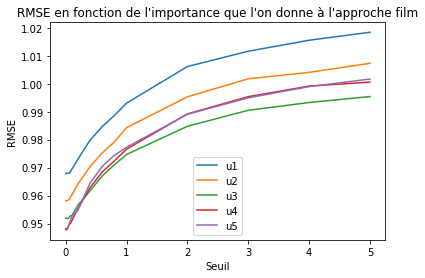

In [114]:
rmses_hybrid=[]
for u in us:
# Hybridation
    truth=load_npz('Matrices/100k/u'+str(u)+'/test_data_u'+str(u)+'.npz')
    temp=[]
    
    seuils= [0,0.002,0.004,0.006,0.008,0.01,0.02,0.04,0.06,0.08,0.1,0.2,0.4,0.6,0.8,1,2,3,4,5]
   
    for seuil in seuils:
        pred_hybrid=load_npz('Matrices/100k/u'+str(u)+'/pred_hybrid_u'+str(u)+'_seuil='+str(seuil)+'.npz')
        temp.append(rmse(pred_hybrid,truth))
    
    rmses_hybrid.append(temp)

rmses_hybrid=np.array(rmses_hybrid).T

fig, ax = plt.subplots()
for u in [1,2,3,4,5]:
    ax.plot(seuils,rmses_hybrid[:,u-1],label='u'+str(u))
    
legend = ax.legend(loc='lower center')
plt.title("RMSE en fonction de l'importance que l'on donne à l'approche film")
plt.xlabel("Seuil")
plt.ylabel('RMSE');
plt.show()
plt.show()

- Plus on choisit un seuil faible, moins on fait confiance à l'approche film
- Pour un seuil nul on fait uniquement confiance à l'approche utilisateur
- Pour des petits seuils la pente des courbes diminue -> l'approche utilisateur devient moins performante
- L'hybridation est peu concluante 

# 6. Fonction de recommandation

- Recommander des films selon la méthode CF utilisateurs ou CF film
- Prédire les notes des films non-vus
- Choisir les n maximums

In [115]:
import heapq

def recommend(u,ratings_matrix,films, method,n):
    """
    Objet : recommande des films pour un utilisateur donné
    Arguments : - u : un utilisateur
                - ratings_matrix : matrice des vrais note
                - films : la table des films 
                - method : 'film' ou 'user' (seulement les méthodes CF)
                - n : le nombre de recommandations voulues
    Sortie : une table des n premiers films recommandés
    """
    ratings_u=ratings_matrix[u,:]
    films_not_seen=np.where(ratings_u.todense() == 0)[1]
    ratings_pred=np.zeros((films_not_seen.shape[0],1))
    bar = progressbar.ProgressBar(maxval=films_not_seen.shape[0], \
    widgets=[' [', progressbar.Timer(), '] ',progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    if method=='film':
        similarity = cosine_similarities(ratings_matrix)
        i=0
        for f in films_not_seen :
            ratings_pred[i]=predict(u,f,ratings_matrix,similarity,'film')
            i=i+1
            bar.update(i)
        bar.finish()
        max_rate_index=heapq.nlargest(n, range(len(ratings_pred)), ratings_pred.take)
        return films.movie_title[films_not_seen[max_rate_index]]
        
    if method=='user':
        similarity = cosine_similarities(ratings_matrix.T)
        i=0
        for f in films_not_seen :
            ratings_pred[i]=predict(u,f,ratings_matrix,similarity,'user')
            i=i+1
            bar.update(i)
        bar.finish()
        max_rate_index=heapq.nlargest(n, range(len(ratings_pred)), ratings_pred.take)
        return films.movie_title[films_not_seen[max_rate_index]]

In [41]:
films=pd.read_csv('ml-100k/u.item', sep='|', names=i_cols,encoding='latin-1')
ratings=read_data_100k('ml-100k/u.data')

In [42]:
recommend(8,ratings,films,'film',5)

 [Elapsed Time: 0:00:20] [===============================================] 100%


1653    Chairman of the Board (1998)
1499       Santa with Muscles (1996)
1660             New Age, The (1994)
1490         Tough and Deadly (1995)
1485     Girl in the Cadillac (1995)
Name: movie_title, dtype: object

In [43]:
recommend(8,ratings,films,'user',5)

 [Elapsed Time: 0:00:31] [===============================================] 100%


813            Great Day in Harlem, A (1994)
1535                    Aiqing wansui (1994)
1466    Saint of Fort Washington, The (1993)
1499               Santa with Muscles (1996)
1598           Someone Else's America (1995)
Name: movie_title, dtype: object

# 7. Passage à 1 million de notes

In [74]:
def read_data_1m(filename):
    """
    Objet : retourne une matrice creuse qui contient les notes données par les utilisateurs aux films
    Arguments : le chemin du fichier des données sous format .base ou .test
    Sortie : matrice creuse des notes
    """
        
    data = pd.read_csv(filename, sep='::', names=header,engine='python')
    
    n_u = max(data.user_id)
    n_f = max(data.item_id)
    
    users=[]
    films=[]
    ratings=[]
    
    
    for line in data.itertuples():
        users.append(line[1]-1)
        films.append(line[2]-1)
        ratings.append(line[3])
        
    return csr_matrix((ratings, (users, films)), shape=(n_u, n_f))

In [45]:
ratings=read_data_1m('ml-1m/ratings.dat')
films=pd.read_csv('ml-1m/movies.dat', sep='::', names=i_cols,encoding='latin-1',engine='python')

In [46]:
recommend(8,ratings,films,'film',5)

 [Elapsed Time: 0:08:56] [===============================================] 100%


3279                            Night Visitor, The (1970)
3171                                Big Tease, The (1999)
3296                                Searchers, The (1956)
1831    Children of Heaven, The (Bacheha-Ye Aseman) (1...
3778                                   Silent Fall (1994)
Name: movie_title, dtype: object

In [47]:
recommend(8,ratings,films,'user',5)

 [Elapsed Time: 0:11:20] [===============================================] 100%


3381                Grumpy Old Men (1993)
556     Beans of Egypt, Maine, The (1994)
571            Little Rascals, The (1994)
988      Associate, The (L'Associe)(1982)
1829               Land Girls, The (1998)
Name: movie_title, dtype: object

# Conclusion

- Bilan des différentes approches
- Hybridation peu concluante
- Explorer d'autres techniques : SVD